In [1]:
from data.attribute import *

In [2]:
from data.selects import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [70]:
year = selects_df[YEAR_ATTR].max()
selects_year_df = selects_df[selects_df[YEAR_ATTR] == year]
population_year_df = population_df[(population_df[YEAR_ATTR] == year) & (population_df[IS_PERMANENT_RESIDENT_ATTR])]
electorate_year_df = population_year_df[(population_year_df[IS_CITIZEN_ATTR]) & (population_year_df[AGE_ATTR] >= 18)]

year

np.uint16(2019)

In [71]:
def merge_proportional(distribution: pd.Series, *distributions: tuple[pd.Series, ...]) -> pd.DataFrame:
    distributions = [distribution] + list(distributions)
    return pd.concat([d / d.sum() for d in distributions], axis=1)

<Axes: xlabel='Age'>

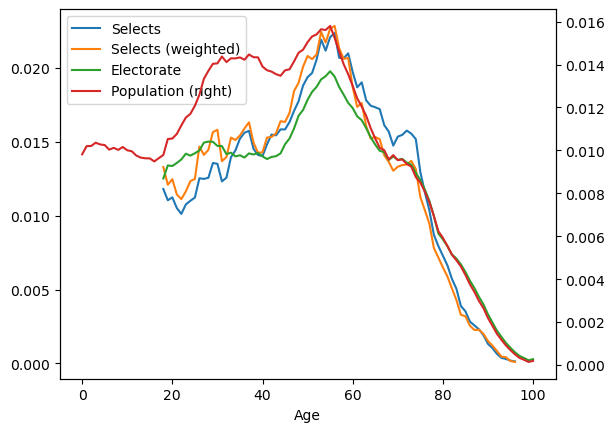

In [73]:
AVERAGE_YEARS = 5
selects_age = selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum() \
    .rolling(AVERAGE_YEARS, center=True, min_periods=1).mean() \
    .rename('Selects')
weighted_selects_age = selects_year_df.groupby(AGE_ATTR) \
    ['weighttot'].sum() \
    .rolling(AVERAGE_YEARS, center=True, min_periods=1).mean() \
    .rename('Selects (weighted)')
electorate_age = electorate_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Electorate')
population_age = population_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Population')

merge_proportional(
    selects_age, weighted_selects_age, electorate_age, population_age
).sort_index().plot(secondary_y=['Population'])

<Axes: xlabel='Sex'>

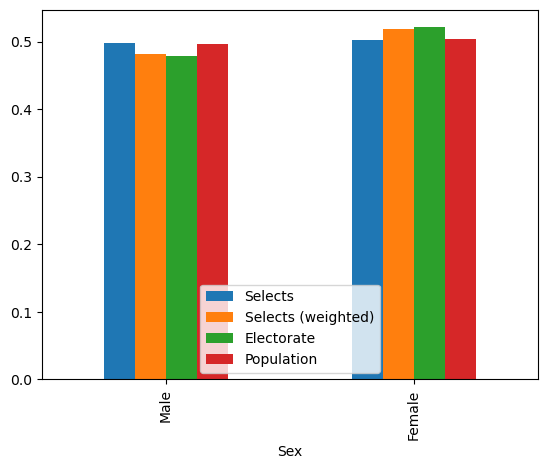

In [74]:
selects_sex = selects_year_df.groupby(SEX_ATTR) \
    ['weightc'].sum() \
    .rename('Selects')
weighted_selects_sex = selects_year_df.groupby(SEX_ATTR) \
    ['weighttot'].sum() \
    .rename('Selects (weighted)')
electorate_sex = electorate_year_df.groupby(SEX_ATTR)[POPULATION_ATTR].sum().rename('Electorate')
population_sex = population_year_df.groupby(SEX_ATTR)[POPULATION_ATTR].sum().rename('Population')

merge_proportional(
    selects_sex, weighted_selects_sex, electorate_sex, population_sex
).rename(SEX_LABEL_MAPPER).plot(kind='bar')

<Axes: xlabel='Commune size'>

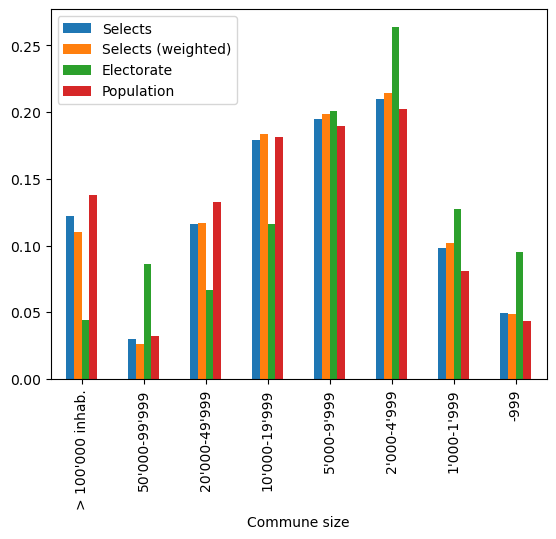

In [75]:
selects_commune_size = selects_year_df.groupby('sg7b', observed=True) \
    ['weightc'].sum().rename('Selects')
weighted_selects_commune_size = selects_year_df.groupby('sg7b', observed=True) \
    ['weighttot'].sum().rename('Selects (weighted)')


def _label_community_size(population: int) -> str:
    if population > 100000:
        return '> 100\'000 inhab.'
    if population > 50000:
        return '50\'000-99\'999'
    if population > 20000:
        return '20\'000-49\'999'
    if population > 10000:
        return '10\'000-19\'999'
    if population > 5000:
        return '5\'000-9\'999'
    if population > 2000:
        return '2\'000-4\'999'
    if population > 1000:
        return '1\'000-1\'999'
    return '-999'


electorate_postal_code = electorate_year_df.groupby(POSTAL_CODE_ATTR)[POPULATION_ATTR].sum()
electorate_commune_size = electorate_postal_code.groupby(
    lambda i: _label_community_size(electorate_postal_code[i])
).sum().rename('Electorate')
population_postal_code = population_year_df.groupby(POSTAL_CODE_ATTR)[POPULATION_ATTR].sum()
population_commune_size = population_postal_code.groupby(
    lambda i: _label_community_size(population_postal_code[i])
).sum().rename('Population')

merge_proportional(
    selects_commune_size, weighted_selects_commune_size, electorate_commune_size, population_commune_size
).plot(kind='bar', xlabel='Commune size')